# Fine-tuning XLM-RoBERTa for Multilingual NER

## Overview
This notebook fine-tunes a multilingual transformer model on both English and French LitBank datasets.

**Content**
1. Load preprocessed English and French data from Notebook 1
2. Combine datasets for joint multilingual training
3. Configure XLM-RoBERTa for token classification
4. Handle subword tokenization (critical for transformers)
5. Train using Hugging Face Trainer on combined data
6. Evaluate separately on English and French test sets
7. Visualize results (F1 scores, confusion matrices, training curves)
8. Compare cross-lingual performance

**Model: XLM-RoBERTa**
- Multilingual (Pre-trained on 100 languages)
- State-of-the-art performance on sequence labeling
- Enables cross-lingual transfer learning

**Training Strategy:**
- **Train/Dev**: Combined English + French (joint training)
- **Evaluation**: Separate English and French test sets (to measure per-language performance)

In [1]:
# Import required libraries
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Tuple
from tqdm.auto import tqdm

# Hugging Face Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification
)
from datasets import Dataset

# Evaluation metrics
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported")
print("\nNote: First run will download XLM-RoBERTa (~1GB).")

✓ Libraries imported

Note: First run will download XLM-RoBERTa (~1GB).


In [2]:
# Configure paths
PROCESSED_DATA_PATH = Path("../data/processed")
MODEL_OUTPUT_PATH = Path("../models")
RESULTS_PATH = Path("../results")

MODEL_OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

# Model configuration
MODEL_NAME = "xlm-roberta-base"  # Multilingual model
MAX_LENGTH = 512  # Maximum sequence length (tokens)
BATCH_SIZE = 16   # Adjust based on your GPU memory (8/16/32)
LEARNING_RATE = 2e-5  # Standard for fine-tuning transformers
NUM_EPOCHS = 3    # Typically 3-5 epochs for NER

print(f"✓ Configuration loaded")
print(f"  Model: {MODEL_NAME}")
print(f"  Max length: {MAX_LENGTH} tokens")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")

✓ Configuration loaded
  Model: xlm-roberta-base
  Max length: 512 tokens
  Batch size: 16
  Learning rate: 2e-05
  Epochs: 3


## 1. Load Preprocessed Data

Load the JSON files created in Notebook 1.

In [3]:
def load_processed_data(data_path: Path) -> Tuple[Dict, Dataset, Dataset, Dataset, Dataset]:
    """
    Load preprocessed JSON data and convert to Hugging Face Dataset format.
    Combines English and French datasets for multilingual training.
    
    WHY: Training on both languages simultaneously enables cross-lingual transfer.
    
    Returns:
        label_mapping: {"label2id": {...}, "id2label": {...}}
        train_dataset: Combined English + French training examples
        dev_dataset: Combined English + French validation examples
        english_test_dataset: English-only test examples
        french_test_dataset: French-only test examples
    """
    # Load label mapping
    with open(data_path / "label_mapping.json", 'r', encoding='utf-8') as f:
        label_mapping = json.load(f)
    
    # Load English datasets
    with open(data_path / "english_train.json", 'r', encoding='utf-8') as f:
        english_train = json.load(f)
    
    with open(data_path / "english_dev.json", 'r', encoding='utf-8') as f:
        english_dev = json.load(f)
    
    with open(data_path / "english_test.json", 'r', encoding='utf-8') as f:
        english_test = json.load(f)
    
    # Load French datasets
    with open(data_path / "french_train.json", 'r', encoding='utf-8') as f:
        french_train = json.load(f)
    
    with open(data_path / "french_dev.json", 'r', encoding='utf-8') as f:
        french_dev = json.load(f)
    
    with open(data_path / "french_test.json", 'r', encoding='utf-8') as f:
        french_test = json.load(f)
    
    # Combine train and dev datasets from both languages
    combined_train = english_train + french_train
    combined_dev = english_dev + french_dev
    
    # Convert to Hugging Face Dataset format
    train_dataset = Dataset.from_list(combined_train)
    dev_dataset = Dataset.from_list(combined_dev)
    english_test_dataset = Dataset.from_list(english_test)
    french_test_dataset = Dataset.from_list(french_test)
    
    print(f"✓ Loaded preprocessed data from {data_path}")
    print(f"\nEnglish datasets:")
    print(f"  Train: {len(english_train)} examples")
    print(f"  Dev:   {len(english_dev)} examples")
    print(f"  Test:  {len(english_test)} examples")
    print(f"\nFrench datasets:")
    print(f"  Train: {len(french_train)} examples")
    print(f"  Dev:   {len(french_dev)} examples")
    print(f"  Test:  {len(french_test)} examples")
    print(f"\nCombined for training:")
    print(f"  Train: {len(train_dataset)} examples (EN + FR)")
    print(f"  Dev:   {len(dev_dataset)} examples (EN + FR)")
    print(f"  Labels: {len(label_mapping['label2id'])} unique tags")
    
    return label_mapping, train_dataset, dev_dataset, english_test_dataset, french_test_dataset


# Load data
label_mapping, train_dataset, dev_dataset, english_test_dataset, french_test_dataset = load_processed_data(PROCESSED_DATA_PATH)

# Convert string keys to integers for model
id2label = {int(k): v for k, v in label_mapping["id2label"].items()}
label2id = label_mapping["label2id"]

print(f"\nLabel mapping preview:")
for idx in sorted(id2label.keys())[:10]:
    print(f"  {idx}: {id2label[idx]}")

✓ Loaded preprocessed data from ../data/processed

English datasets:
  Train: 5577 examples
  Dev:   747 examples
  Test:  693 examples

French datasets:
  Train: 5130 examples
  Dev:   1313 examples
  Test:  1406 examples

Combined for training:
  Train: 10707 examples (EN + FR)
  Dev:   2060 examples (EN + FR)
  Labels: 15 unique tags

Label mapping preview:
  0: O
  1: B-FAC
  2: B-GPE
  3: B-LOC
  4: B-ORG
  5: B-PER
  6: B-TIME
  7: B-VEH
  8: I-FAC
  9: I-GPE


## 2. Tokenization and Label Alignment

Transformers use subword tokenization (WordPiece/BPE), while labels correspond to words. Which subwords get the label?

**First-token strategy** : the first subword receives the label, subsequent tokens will be ignored (the `-100` label tells PyTorch to ignore these tokens when computing loss.)

In [4]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"✓ Loaded tokenizer: {MODEL_NAME}")

# Example: Show subword tokenization
example_text = "Dr. Frankenstein visited Switzerland"
tokens = tokenizer.tokenize(example_text)
print(f"\nExample tokenization:")
print(f"  Input:  {example_text}")
print(f"  Tokens: {tokens}")
print(f"\nNotice how 'Frankenstein' and 'Switzerland' are split into subwords!")

✓ Loaded tokenizer: xlm-roberta-base

Example tokenization:
  Input:  Dr. Frankenstein visited Switzerland
  Tokens: ['▁Dr', '.', '▁Frank', 'enstein', '▁visite', 'd', '▁Switzerland']

Notice how 'Frankenstein' and 'Switzerland' are split into subwords!


In [5]:
def tokenize_and_align_labels(examples: Dict) -> Dict:
    """
    Tokenize input and align NER labels with subword tokens.
    
    WHY: This is the most critical function for NER with transformers!
    Without proper alignment, your model will learn incorrect labels.
    
    Process:
    1. Tokenize words into subwords
    2. For each subword, determine which original word it came from
    3. Assign labels:
       - First subword of word → original label
       - Continuation subwords → -100 (ignored)
       - Special tokens ([CLS], [SEP]) → -100 (ignored)
    
    Args:
        examples: Batch of examples with "tokens" and "ner_tags"
        
    Returns:
        Tokenized inputs with aligned labels
    """
    # Tokenize all examples
    # is_split_into_words=True tells tokenizer we already have word tokens
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        max_length=MAX_LENGTH,
        is_split_into_words=True,
        padding=False  # We'll pad dynamically in batches
    )
    
    all_labels = []
    
    # Process each example in the batch
    for i, labels in enumerate(examples["ner_tags"]):
        # word_ids() returns which original word each token came from
        # Example: [None, 0, 1, 1, 2, None] means:
        #   - Token 0: special token ([CLS])
        #   - Token 1: from word 0
        #   - Token 2-3: from word 1 (subwords!)
        #   - Token 4: from word 2
        #   - Token 5: special token ([SEP])
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        
        previous_word_idx = None
        label_ids = []
        
        for word_idx in word_ids:
            # Special tokens (None) → -100
            if word_idx is None:
                label_ids.append(-100)
            
            # First subword of a word → original label
            elif word_idx != previous_word_idx:
                label_ids.append(labels[word_idx])
            
            # Continuation subwords → -100
            else:
                label_ids.append(-100)
            
            previous_word_idx = word_idx
        
        all_labels.append(label_ids)
    
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs


print("✓ Tokenization function defined")
print("\nKey concept: -100 labels are ignored during training")
print("This prevents the model from being penalized for subword predictions!")

✓ Tokenization function defined

Key concept: -100 labels are ignored during training
This prevents the model from being penalized for subword predictions!


In [6]:
# Apply tokenization to all datasets
print("Tokenizing datasets...")

tokenized_train = train_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=train_dataset.column_names,
    desc="Tokenizing training data"
)

tokenized_dev = dev_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dev_dataset.column_names,
    desc="Tokenizing dev data"
)

tokenized_english_test = english_test_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=english_test_dataset.column_names,
    desc="Tokenizing English test data"
)

tokenized_french_test = french_test_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=french_test_dataset.column_names,
    desc="Tokenizing French test data"
)

print("\n✓ Tokenization complete!")
print(f"\nExample tokenized input:")
example = tokenized_train[0]
print(f"  Input IDs shape: {len(example['input_ids'])}")
print(f"  Labels shape:    {len(example['labels'])}")
print(f"  First 10 tokens: {tokenizer.convert_ids_to_tokens(example['input_ids'][:10])}")
print(f"  First 10 labels: {example['labels'][:10]}")

Tokenizing datasets...


Tokenizing training data:   0%|          | 0/10707 [00:00<?, ? examples/s]

Tokenizing dev data:   0%|          | 0/2060 [00:00<?, ? examples/s]

Tokenizing English test data:   0%|          | 0/693 [00:00<?, ? examples/s]

Tokenizing French test data:   0%|          | 0/1406 [00:00<?, ? examples/s]


✓ Tokenization complete!

Example tokenized input:
  Input IDs shape: 25
  Labels shape:    25
  First 10 tokens: ['<s>', '▁CHA', 'P', 'TER', '▁1', '▁', '.', '▁A', '▁Not', '▁Un']
  First 10 labels: [-100, 0, -100, -100, 0, 0, -100, 0, 0, 0]


## 3. Load Model

Load XLM-RoBERTa and add a token classification head on top.

In [7]:
# Load pre-trained model
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True  # Since we're adding a new classification head
)

print(f"✓ Loaded model: {MODEL_NAME}")
print(f"  Parameters: {model.num_parameters():,}")
print(f"  Output labels: {model.num_labels}")
print(f"\nModel architecture:")
print(f"  1. XLM-RoBERTa encoder (pre-trained on 100 languages)")
print(f"  2. Token classification head (randomly initialized, will be trained)")

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Loaded model: xlm-roberta-base
  Parameters: 277,464,591
  Output labels: 15

Model architecture:
  1. XLM-RoBERTa encoder (pre-trained on 100 languages)
  2. Token classification head (randomly initialized, will be trained)


## 4. Define Evaluation Metrics

**Seqeval**
- Standard NER evaluation library
- Computes entity-level F1 (not token-level)

**Metrics:**
- **Precision**: Of predicted entities, how many were correct?
- **Recall**: Of true entities, how many were found?
- **F1**: Harmonic mean of precision and recall

In [8]:
def compute_metrics(pred):
    """
    Compute evaluation metrics during training.
    
    WHY: This function is called by Trainer after each evaluation.
    It converts model predictions back to BIO tags and computes F1.
    
    Args:
        pred: Predictions object with logits and labels
        
    Returns:
        Dictionary with precision, recall, f1, accuracy
    """
    predictions, labels = pred
    
    # Get predicted class for each token (argmax over logits)
    predictions = np.argmax(predictions, axis=2)
    
    # Convert to BIO tag strings (removing -100 labels)
    true_labels = []
    true_predictions = []
    
    for prediction, label in zip(predictions, labels):
        true_label = []
        true_pred = []
        
        for pred_id, label_id in zip(prediction, label):
            # Skip -100 labels (subwords and special tokens)
            if label_id != -100:
                true_label.append(id2label[label_id])
                true_pred.append(id2label[pred_id])
        
        true_labels.append(true_label)
        true_predictions.append(true_pred)
    
    # Compute entity-level metrics using seqeval
    results = {
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions),
    }
    
    return results


print("✓ Evaluation metrics defined")
print("  Using seqeval for entity-level F1 scoring")

✓ Evaluation metrics defined
  Using seqeval for entity-level F1 scoring


## 5. Training Configuration

**Key hyperparameters**
- **Learning rate**: How big the update steps are (2e-5 is standard for fine-tuning)
- **Batch size**: Number of examples processed together (larger = faster but more memory)
- **Epochs**: Full passes through training data (3-5 typical for NER)
- **Warmup**: Gradually increase learning rate at start (stabilizes training)
- **Weight decay**: Regularization to prevent overfitting

In [9]:
# Define training arguments
training_args = TrainingArguments(
    output_dir=str(MODEL_OUTPUT_PATH / "checkpoints"),
    
    # Training hyperparameters
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,  # L2 regularization
    
    # Evaluation and logging
    eval_strategy="epoch",  # Evaluate after each epoch
    save_strategy="epoch",  # Save checkpoint after each epoch
    logging_steps=100,      # Log every 100 steps
    load_best_model_at_end=True,  # Load best checkpoint at end
    metric_for_best_model="f1",    # Use F1 to select best model
    
    # Performance optimizations
    fp16=False,  # Set to True if you have a GPU with FP16 support
    dataloader_num_workers=0,  # Increase if you have multiple CPU cores
    
    # Reporting
    report_to="none",  # Disable wandb/tensorboard (can enable if desired)
    
    # Other settings
    push_to_hub=False,
    seed=42,  # For reproducibility
)

# Data collator (handles dynamic padding)
data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer,
    padding=True  # Pad to longest sequence in batch
)

print("✓ Training configuration ready")
print(f"\nTotal training steps: ~{len(tokenized_train) // BATCH_SIZE * NUM_EPOCHS}")
print(f"Evaluation: After each epoch")
print(f"Best model selected by: F1 score")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


✓ Training configuration ready

Total training steps: ~2007
Evaluation: After each epoch
Best model selected by: F1 score


## 6. Train the Model

**Training loop**
1. Model reads tokenized text
2. Predicts label probabilities for each token
3. Compares predictions to true labels (cross-entropy loss)
4. Updates weights via backpropagation
5. Repeats for all batches (1 epoch)
6. Evaluates on dev set
7. Repeats for NUM_EPOCHS

In [10]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_dev,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("✓ Trainer initialized")
print("\nStarting training...")
print("This may take 10-60 minutes depending on your hardware.")
print("Progress bar will show training and evaluation metrics.\n")

✓ Trainer initialized

Starting training...
This may take 10-60 minutes depending on your hardware.
Progress bar will show training and evaluation metrics.



In [11]:
# Train!
train_result = trainer.train()

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)
print(f"\nTraining metrics:")
print(f"  Total training time: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"  Training loss: {train_result.metrics['train_loss']:.4f}")

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.225800,0.236881,0.621019,0.708061,0.661690
2,0.168900,0.234873,0.679757,0.703946,0.691640
3,0.131600,0.226292,0.682273,0.726701,0.703786



TRAINING COMPLETE!

Training metrics:
  Total training time: 119.44 seconds
  Training loss: 0.2077


## 7. Save the Model

Save the best model for use in Notebook 3 (evaluation).

In [12]:
# Save model and tokenizer
final_model_path = MODEL_OUTPUT_PATH / "litbank-xlm-roberta"
trainer.save_model(str(final_model_path))
tokenizer.save_pretrained(str(final_model_path))

print(f"✓ Model saved to: {final_model_path.absolute()}")
print("\nSaved files:")
for file in final_model_path.iterdir():
    print(f"  - {file.name}")

✓ Model saved to: /storage/homefs/nw03x063/CAS_Mod4_NER/notebooks/../models/litbank-xlm-roberta

Saved files:
  - model.safetensors
  - config.json
  - training_args.bin
  - tokenizer_config.json
  - special_tokens_map.json
  - tokenizer.json


## 8. Evaluate on Test Set

Evaluate on the (previously unseen) test set ONCE at the end.

In [13]:
# Evaluate on both test sets separately
print("="*60)
print("EVALUATING ON TEST SETS")
print("="*60)

# Evaluate on English test set
print("\n1. English Test Set")
print("-" * 60)
english_test_results = trainer.evaluate(eval_dataset=tokenized_english_test)

print(f"\nEnglish Test Results:")
print(f"  Precision: {english_test_results['eval_precision']:.4f}")
print(f"  Recall:    {english_test_results['eval_recall']:.4f}")
print(f"  F1 Score:  {english_test_results['eval_f1']:.4f}")

# Evaluate on French test set
print("\n2. French Test Set")
print("-" * 60)
french_test_results = trainer.evaluate(eval_dataset=tokenized_french_test)

print(f"\nFrench Test Results:")
print(f"  Precision: {french_test_results['eval_precision']:.4f}")
print(f"  Recall:    {french_test_results['eval_recall']:.4f}")
print(f"  F1 Score:  {french_test_results['eval_f1']:.4f}")

# Summary comparison
print("\n" + "="*60)
print("SUMMARY: Multilingual Performance")
print("="*60)
print(f"\n{'Language':<15} {'Precision':<12} {'Recall':<12} {'F1 Score':<12}")
print("-" * 60)
print(f"{'English':<15} {english_test_results['eval_precision']:<12.4f} {english_test_results['eval_recall']:<12.4f} {english_test_results['eval_f1']:<12.4f}")
print(f"{'French':<15} {french_test_results['eval_precision']:<12.4f} {french_test_results['eval_recall']:<12.4f} {french_test_results['eval_f1']:<12.4f}")
print("\nNote: Model was trained on combined English + French data")

EVALUATING ON TEST SETS

1. English Test Set
------------------------------------------------------------



English Test Results:
  Precision: 0.6613
  Recall:    0.7008
  F1 Score:  0.6805

2. French Test Set
------------------------------------------------------------

French Test Results:
  Precision: 0.6001
  Recall:    0.7342
  F1 Score:  0.6604

SUMMARY: Multilingual Performance

Language        Precision    Recall       F1 Score    
------------------------------------------------------------
English         0.6613       0.7008       0.6805      
French          0.6001       0.7342       0.6604      

Note: Model was trained on combined English + French data


## 9. Per-Entity Type Evaluation

Model performs on each entity type (PER, LOC, etc.).

In [14]:
def get_detailed_predictions(trainer, dataset, original_dataset):
    """
    Get predictions and convert back to BIO tags for detailed analysis.
    
    Returns:
        true_labels: List of label sequences
        predictions: List of prediction sequences
    """
    # Get predictions
    pred_output = trainer.predict(dataset)
    predictions = np.argmax(pred_output.predictions, axis=2)
    
    true_labels = []
    true_predictions = []
    
    # Convert to BIO tags
    for i, (prediction, label) in enumerate(zip(predictions, pred_output.label_ids)):
        true_label = []
        true_pred = []
        
        for pred_id, label_id in zip(prediction, label):
            if label_id != -100:
                true_label.append(id2label[label_id])
                true_pred.append(id2label[pred_id])
        
        true_labels.append(true_label)
        true_predictions.append(true_pred)
    
    return true_labels, true_predictions


# Get detailed predictions for both test sets
print("\n" + "="*60)
print("GENERATING DETAILED PREDICTIONS")
print("="*60)

print("\nGenerating English test predictions...")
english_true_labels, english_predictions = get_detailed_predictions(
    trainer, tokenized_english_test, english_test_dataset
)

print("Generating French test predictions...")
french_true_labels, french_predictions = get_detailed_predictions(
    trainer, tokenized_french_test, french_test_dataset
)

# Print classification reports for English
print("\n" + "="*60)
print("ENGLISH TEST SET - PER-ENTITY TYPE PERFORMANCE")
print("="*60)
print(classification_report(english_true_labels, english_predictions, digits=4))

# Save English report
english_report_text = classification_report(english_true_labels, english_predictions, digits=4)
with open(RESULTS_PATH / "english_test_classification_report.txt", 'w') as f:
    f.write("English Test Set Classification Report\n")
    f.write("=" * 60 + "\n\n")
    f.write(english_report_text)
print(f"✓ Saved to {RESULTS_PATH / 'english_test_classification_report.txt'}")

# Print classification reports for French
print("\n" + "="*60)
print("FRENCH TEST SET - PER-ENTITY TYPE PERFORMANCE")
print("="*60)
print(classification_report(french_true_labels, french_predictions, digits=4))

# Save French report
french_report_text = classification_report(french_true_labels, french_predictions, digits=4)
with open(RESULTS_PATH / "french_test_classification_report.txt", 'w') as f:
    f.write("French Test Set Classification Report\n")
    f.write("=" * 60 + "\n\n")
    f.write(french_report_text)
print(f"✓ Saved to {RESULTS_PATH / 'french_test_classification_report.txt'}")


GENERATING DETAILED PREDICTIONS

Generating English test predictions...
Generating French test predictions...



ENGLISH TEST SET - PER-ENTITY TYPE PERFORMANCE
              precision    recall  f1-score   support

         FAC     0.5282    0.5337    0.5309       193
         GPE     0.6000    0.8500    0.7034        60
         LOC     0.5172    0.5505    0.5333       109
         ORG     0.1000    0.1667    0.1250         6
         PER     0.7244    0.7523    0.7381       856
         VEH     0.5263    0.6250    0.5714        16

   micro avg     0.6613    0.7008    0.6805      1240
   macro avg     0.4994    0.5797    0.5337      1240
weighted avg     0.6641    0.7008    0.6811      1240

✓ Saved to ../results/english_test_classification_report.txt

FRENCH TEST SET - PER-ENTITY TYPE PERFORMANCE
              precision    recall  f1-score   support

         FAC     0.5656    0.7062    0.6281       177
         GPE     0.5644    0.6552    0.6064        87
         LOC     0.2687    0.4675    0.3412        77
         ORG     0.0000    0.0000    0.0000        12
         PER     0.6667    0.7

In [ ]:
# Detailed BIO-Tag Analysis for English Test Set
print("\n" + "=" * 80)
print("DETAILED BIO-TAG ANALYSIS (English Test Set)")
print("=" * 80)
print("\nThis analysis shows performance for each B- and I- tag separately.")
print("This helps identify specific issues with boundary detection vs. continuation.\n")

# Flatten labels and predictions for token-level analysis
flat_labels = [label for seq in english_true_labels for label in seq]
flat_predictions = [pred for seq in english_predictions for pred in seq]

# Get all unique BIO tags (excluding 'O')
all_tags = sorted(set(flat_labels + flat_predictions))
bio_tags = [tag for tag in all_tags if tag != 'O' and tag.startswith(('B-', 'I-'))]

# Organize tags by entity type
entity_types = sorted(set([tag.split('-')[1] for tag in bio_tags]))

# Compute metrics for each BIO tag
results_per_tag = []

for entity_type in entity_types:
    b_tag = f'B-{entity_type}'
    i_tag = f'I-{entity_type}'
    
    print(f"\n{'─' * 80}")
    print(f"Entity Type: {entity_type}")
    print(f"{'─' * 80}")
    
    for tag in [b_tag, i_tag]:
        if tag not in bio_tags:
            continue
            
        # Count true positives, false positives, false negatives
        tp = sum(1 for true, pred in zip(flat_labels, flat_predictions) 
                if true == tag and pred == tag)
        fp = sum(1 for true, pred in zip(flat_labels, flat_predictions) 
                if true != tag and pred == tag)
        fn = sum(1 for true, pred in zip(flat_labels, flat_predictions) 
                if true == tag and pred != tag)
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        
        support = tp + fn
        
        # Store results
        results_per_tag.append({
            'Entity Type': entity_type,
            'Tag': tag,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'Support': support,
            'TP': tp,
            'FP': fp,
            'FN': fn
        })
        
        # Display results
        print(f"\n  {tag:10s}")
        print(f"    Precision: {precision:.4f}")
        print(f"    Recall:    {recall:.4f}")
        print(f"    F1 Score:  {f1:.4f}")
        print(f"    Support:   {support:4d} tokens")
        print(f"    Details:   TP={tp:3d}, FP={fp:3d}, FN={fn:3d}")

# Create summary DataFrame
import pandas as pd
df_bio_tags = pd.DataFrame(results_per_tag)

print(f"\n{'=' * 80}")
print("SUMMARY TABLE: Performance by BIO Tag")
print(f"{'=' * 80}\n")
print(df_bio_tags[['Tag', 'Precision', 'Recall', 'F1', 'Support']].to_string(index=False))

# Save to file
df_bio_tags.to_csv(RESULTS_PATH / "bio_tag_analysis_english.csv", index=False)
print(f"\n✓ Saved BIO-tag analysis to {RESULTS_PATH / 'bio_tag_analysis_english.csv'}")

# Visualize B- vs I- performance comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Prepare data for visualization
b_tags_df = df_bio_tags[df_bio_tags['Tag'].str.startswith('B-')].copy()
i_tags_df = df_bio_tags[df_bio_tags['Tag'].str.startswith('I-')].copy()

# Extract entity types for x-axis
b_tags_df['Entity'] = b_tags_df['Tag'].str.replace('B-', '')
i_tags_df['Entity'] = i_tags_df['Tag'].str.replace('I-', '')

# Sort by entity type
b_tags_df = b_tags_df.sort_values('Entity')
i_tags_df = i_tags_df.sort_values('Entity')

x = np.arange(len(entity_types))
width = 0.35

# Plot Precision
axes[0].bar(x - width/2, b_tags_df['Precision'], width, label='B- tags', alpha=0.8, color='#1f77b4')
axes[0].bar(x + width/2, i_tags_df['Precision'], width, label='I- tags', alpha=0.8, color='#ff7f0e')
axes[0].set_ylabel('Precision', fontsize=11)
axes[0].set_title('Precision: B- vs I- Tags', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(entity_types, rotation=45)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Plot Recall
axes[1].bar(x - width/2, b_tags_df['Recall'], width, label='B- tags', alpha=0.8, color='#1f77b4')
axes[1].bar(x + width/2, i_tags_df['Recall'], width, label='I- tags', alpha=0.8, color='#ff7f0e')
axes[1].set_ylabel('Recall', fontsize=11)
axes[1].set_title('Recall: B- vs I- Tags', fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(entity_types, rotation=45)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1])

# Plot F1 Score
axes[2].bar(x - width/2, b_tags_df['F1'], width, label='B- tags', alpha=0.8, color='#1f77b4')
axes[2].bar(x + width/2, i_tags_df['F1'], width, label='I- tags', alpha=0.8, color='#ff7f0e')
axes[2].set_ylabel('F1 Score', fontsize=11)
axes[2].set_title('F1 Score: B- vs I- Tags', fontsize=12, fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels(entity_types, rotation=45)
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)
axes[2].set_ylim([0, 1])

plt.suptitle('English Test Set: BIO-Tag Performance Comparison by Entity Type', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(RESULTS_PATH / "bio_tag_comparison_english.png", dpi=300, bbox_inches='tight')
print(f"✓ Saved visualization to {RESULTS_PATH / 'bio_tag_comparison_english.png'}")
plt.show()

# Insights section
print(f"\n{'=' * 80}")
print("KEY INSIGHTS")
print(f"{'=' * 80}")

# Compare B- vs I- performance
avg_b_f1 = b_tags_df['F1'].mean()
avg_i_f1 = i_tags_df['F1'].mean()

print(f"\n1. Overall B- vs I- Performance:")
print(f"   Average F1 for B- tags: {avg_b_f1:.4f}")
print(f"   Average F1 for I- tags: {avg_i_f1:.4f}")
print(f"   Difference: {abs(avg_b_f1 - avg_i_f1):.4f}")

if avg_b_f1 > avg_i_f1:
    print(f"   → Model performs better at detecting entity boundaries (B-) than continuations (I-)")
else:
    print(f"   → Model performs better at entity continuations (I-) than detecting boundaries (B-)")

# Find most challenging tags
print(f"\n2. Most Challenging Tags (Lowest F1):")
bottom_3 = df_bio_tags.nsmallest(3, 'F1')[['Tag', 'F1', 'Support']]
for idx, row in bottom_3.iterrows():
    print(f"   {row['Tag']:10s}: F1={row['F1']:.4f} (support={row['Support']:3d})")

# Find best performing tags
print(f"\n3. Best Performing Tags (Highest F1):")
top_3 = df_bio_tags.nlargest(3, 'F1')[['Tag', 'F1', 'Support']]
for idx, row in top_3.iterrows():
    print(f"   {row['Tag']:10s}: F1={row['F1']:.4f} (support={row['Support']:3d})")

print(f"\n{'=' * 80}")

## 10. Confusion Matrix

Shows which entity types the model confuses:
- Diagonal = correct predictions
- Off-diagonal = errors


CONFUSION MATRICES

1. English Test Set
✓ Saved confusion matrix to ../results/confusion_matrix_english.png


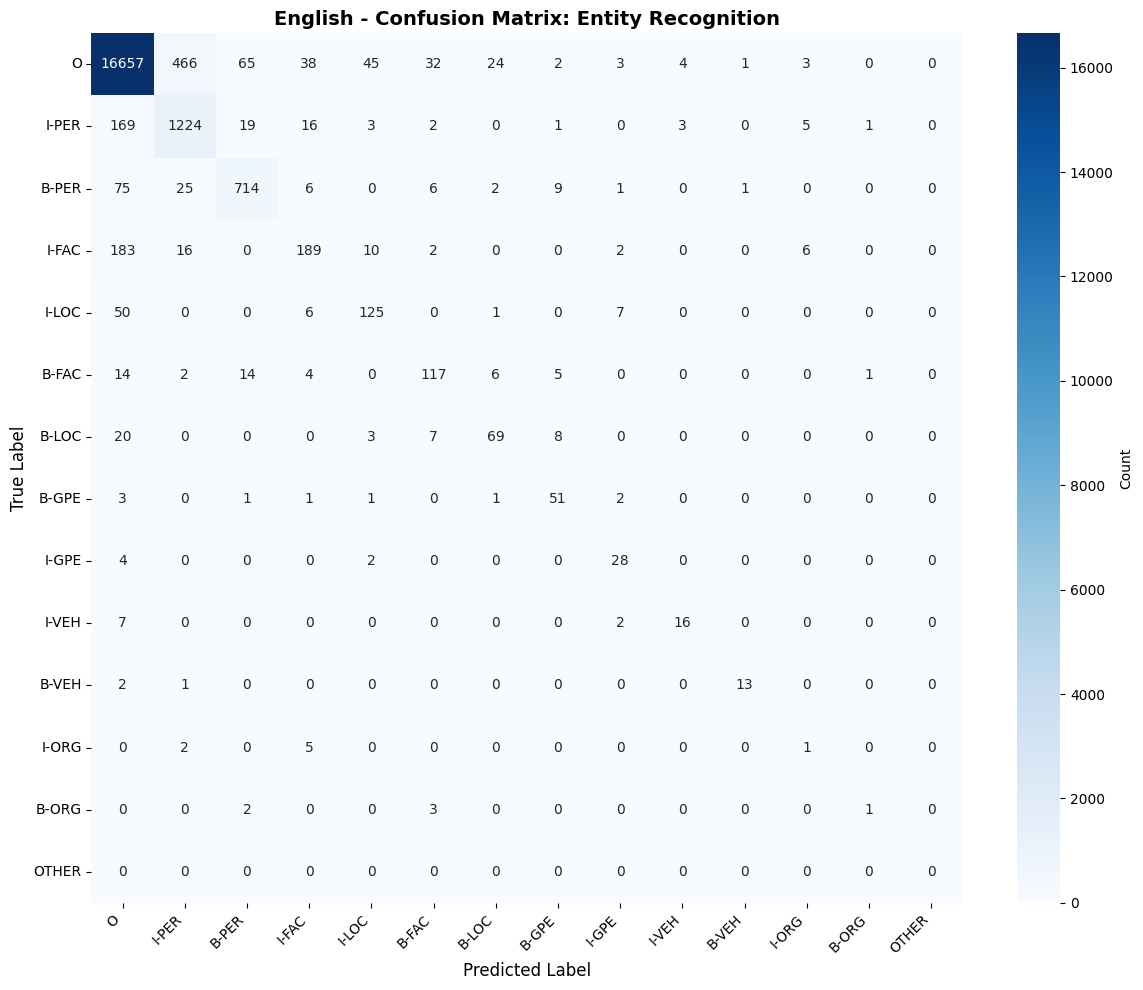


2. French Test Set
✓ Saved confusion matrix to ../results/confusion_matrix_french.png


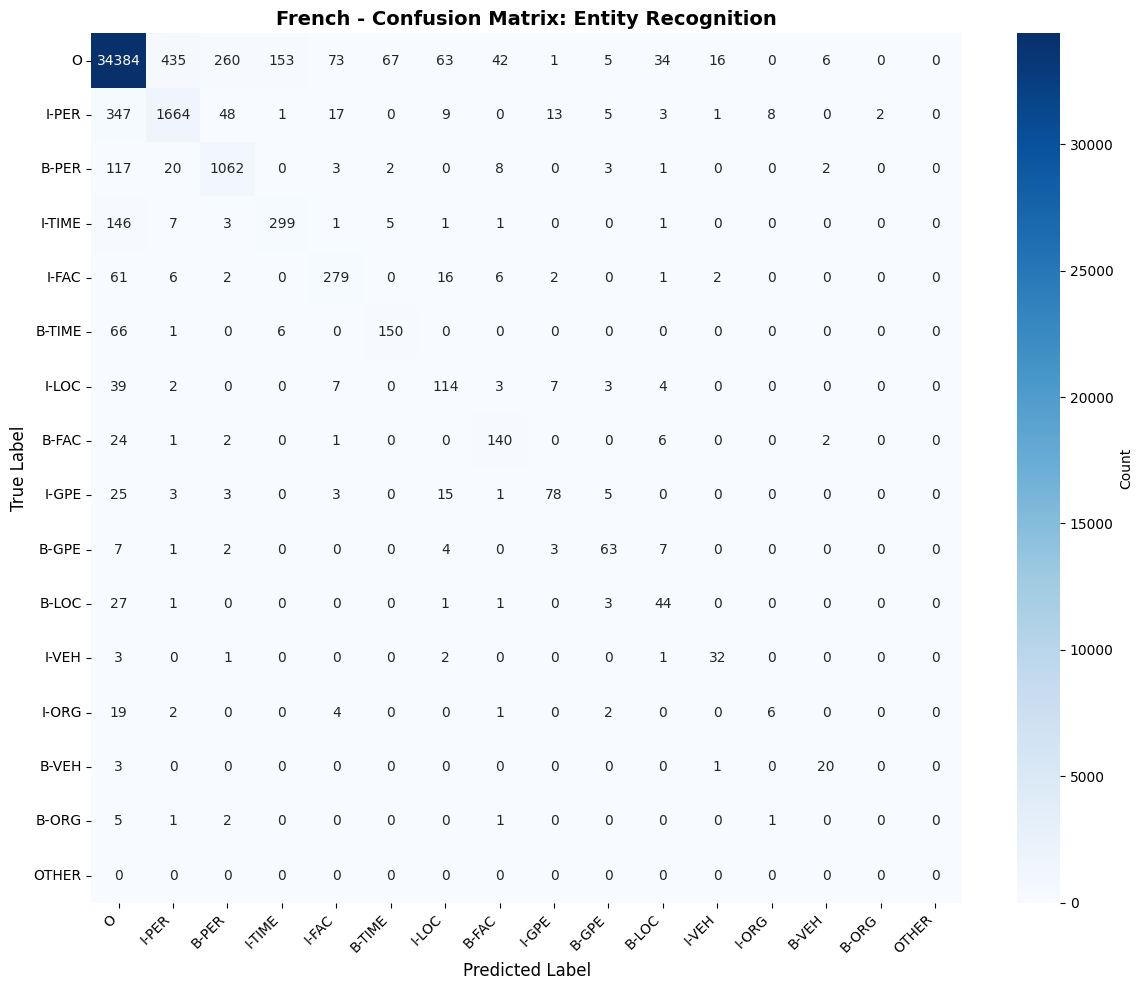

In [15]:
def plot_confusion_matrix(true_labels: List[List[str]], 
                         predictions: List[List[str]], 
                         language: str = "English",
                         save_path: Path = None):
    """
    Create confusion matrix for entity types (B- tags only).
    
    WHY: Focus on entity types (PER, LOC, etc.) rather than BIO positions.
    """
    # Flatten lists and extract entity types
    flat_true = []
    flat_pred = []
    
    for true_seq, pred_seq in zip(true_labels, predictions):
        flat_true.extend(true_seq)
        flat_pred.extend(pred_seq)
    
    # Get unique labels (sorted)
    unique_labels = sorted(set(flat_true + flat_pred))
    
    # For readability, focus on entity types (B- and I- separately)
    # Or just top N most common labels
    from collections import Counter
    label_counts = Counter(flat_true)
    top_labels = [label for label, _ in label_counts.most_common(15)]  # Top 15 labels
    
    # Filter predictions and labels
    filtered_true = [l if l in top_labels else 'OTHER' for l in flat_true]
    filtered_pred = [l if l in top_labels else 'OTHER' for l in flat_pred]
    
    # Create confusion matrix
    cm = confusion_matrix(filtered_true, filtered_pred, labels=top_labels + ['OTHER'])
    
    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=top_labels + ['OTHER'],
        yticklabels=top_labels + ['OTHER'],
        cbar_kws={'label': 'Count'}
    )
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(f'{language} - Confusion Matrix: Entity Recognition', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved confusion matrix to {save_path}")
    
    plt.show()


# Create confusion matrices for both languages
print("\n" + "="*60)
print("CONFUSION MATRICES")
print("="*60)

print("\n1. English Test Set")
plot_confusion_matrix(
    english_true_labels, 
    english_predictions,
    language="English",
    save_path=RESULTS_PATH / "confusion_matrix_english.png"
)

print("\n2. French Test Set")
plot_confusion_matrix(
    french_true_labels, 
    french_predictions,
    language="French",
    save_path=RESULTS_PATH / "confusion_matrix_french.png"
)

## 11. Training Curves

Visualize learning progress over time.

✓ Saved training curves to ../results/training_curves.png


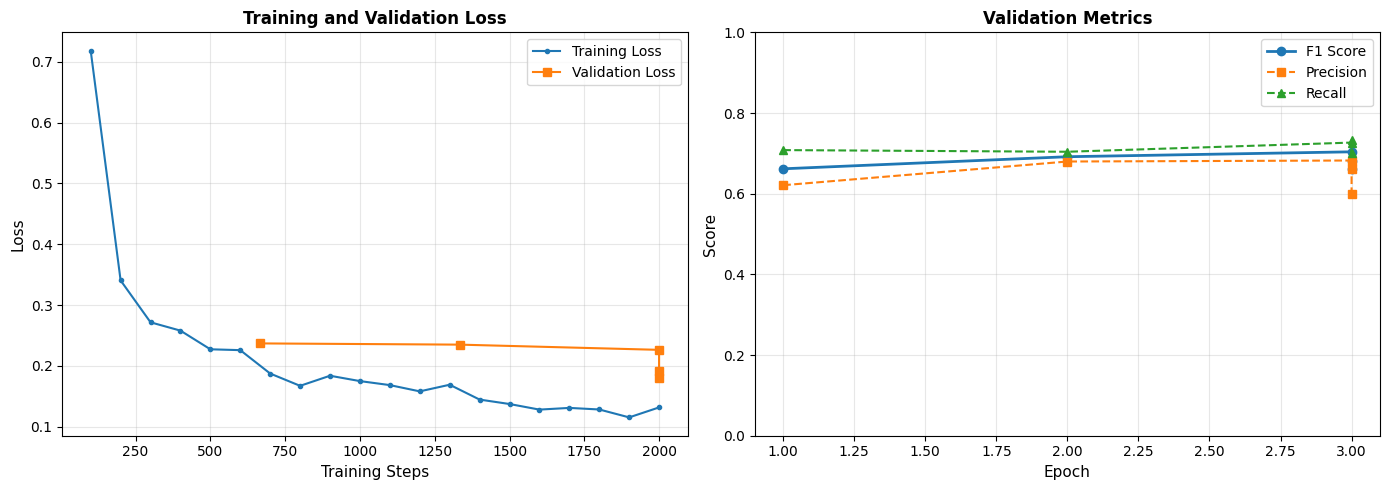

In [16]:
def plot_training_curves(trainer, save_path: Path = None):
    """
    Plot training and validation metrics over epochs.
    
    WHY: Helps diagnose:
    - Overfitting (train improves, val plateaus)
    - Underfitting (both metrics poor)
    - Convergence (metrics stabilize)
    """
    # Extract metrics from log history
    log_history = trainer.state.log_history
    
    # Separate training and evaluation logs
    train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
    eval_logs = [log for log in log_history if 'eval_loss' in log]
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Loss curves
    if train_logs and eval_logs:
        train_steps = [log['step'] for log in train_logs if 'loss' in log]
        train_loss = [log['loss'] for log in train_logs if 'loss' in log]
        
        eval_epochs = [log['epoch'] for log in eval_logs]
        eval_loss = [log['eval_loss'] for log in eval_logs]
        
        axes[0].plot(train_steps, train_loss, label='Training Loss', marker='o', markersize=3)
        # Align eval_loss with train steps (approximate)
        if train_steps and eval_epochs:
            steps_per_epoch = max(train_steps) / max(eval_epochs) if eval_epochs else 1
            eval_steps = [epoch * steps_per_epoch for epoch in eval_epochs]
            axes[0].plot(eval_steps, eval_loss, label='Validation Loss', marker='s', markersize=6)
        
        axes[0].set_xlabel('Training Steps', fontsize=11)
        axes[0].set_ylabel('Loss', fontsize=11)
        axes[0].set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
        axes[0].legend()
        axes[0].grid(alpha=0.3)
    
    # Plot 2: F1 Score progression
    if eval_logs:
        eval_epochs = [log['epoch'] for log in eval_logs]
        eval_f1 = [log.get('eval_f1', 0) for log in eval_logs]
        eval_precision = [log.get('eval_precision', 0) for log in eval_logs]
        eval_recall = [log.get('eval_recall', 0) for log in eval_logs]
        
        axes[1].plot(eval_epochs, eval_f1, label='F1 Score', marker='o', linewidth=2)
        axes[1].plot(eval_epochs, eval_precision, label='Precision', marker='s', linestyle='--')
        axes[1].plot(eval_epochs, eval_recall, label='Recall', marker='^', linestyle='--')
        
        axes[1].set_xlabel('Epoch', fontsize=11)
        axes[1].set_ylabel('Score', fontsize=11)
        axes[1].set_title('Validation Metrics', fontsize=12, fontweight='bold')
        axes[1].legend()
        axes[1].grid(alpha=0.3)
        axes[1].set_ylim([0, 1])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved training curves to {save_path}")
    
    plt.show()


# Plot training curves
plot_training_curves(
    trainer,
    save_path=RESULTS_PATH / "training_curves.png"
)

## 12. Example Predictions

Visualize some predictions to understand model behavior.

In [17]:
def show_predictions(tokens: List[str], true_labels: List[str], predictions: List[str], language: str = "English", num_examples: int = 3):
    """
    Display predictions with color-coded entities.
    """
    print("\n" + "="*80)
    print(f"{language.upper()} - EXAMPLE PREDICTIONS")
    print("="*80)
    
    for i in range(min(num_examples, len(tokens))):
        print(f"\nExample {i+1}:")
        print("-" * 80)
        
        token_seq = tokens[i]
        true_seq = true_labels[i]
        pred_seq = predictions[i]
        
        # Display first 50 tokens
        display_len = min(50, len(token_seq))
        
        for j in range(display_len):
            token = token_seq[j]
            true_label = true_seq[j]
            pred_label = pred_seq[j]
            
            # Mark correct/incorrect
            marker = "✓" if true_label == pred_label else "✗"
            
            if true_label != 'O' or pred_label != 'O':
                print(f"  {token:20s} | True: {true_label:12s} | Pred: {pred_label:12s} {marker}")
        
        if len(token_seq) > display_len:
            print(f"  ... ({len(token_seq) - display_len} more tokens)")


# Show examples from both languages
print("\n" + "="*80)
print("EXAMPLE PREDICTIONS FROM BOTH LANGUAGES")
print("="*80)

# English examples
show_predictions(
    [ex['tokens'] for ex in english_test_dataset],
    english_true_labels,
    english_predictions,
    language="English",
    num_examples=2
)

# French examples
show_predictions(
    [ex['tokens'] for ex in french_test_dataset],
    french_true_labels,
    french_predictions,
    language="French",
    num_examples=2
)


EXAMPLE PREDICTIONS FROM BOTH LANGUAGES

ENGLISH - EXAMPLE PREDICTIONS

Example 1:
--------------------------------------------------------------------------------
  Chancery             | True: B-FAC        | Pred: B-GPE        ✗
  London               | True: B-GPE        | Pred: I-GPE        ✗
  Michaelmas           | True: O            | Pred: B-PER        ✗
  the                  | True: O            | Pred: B-PER        ✗
  Lord                 | True: B-PER        | Pred: I-PER        ✗
  Chancellor           | True: I-PER        | Pred: I-PER        ✓
  Lincoln              | True: B-FAC        | Pred: B-PER        ✗
  's                   | True: I-FAC        | Pred: I-FAC        ✓
  Inn                  | True: I-FAC        | Pred: I-FAC        ✓
  Hall                 | True: I-FAC        | Pred: I-FAC        ✓

Example 2:
--------------------------------------------------------------------------------
  the                  | True: B-FAC        | Pred: B-FAC        ✓
  str

## Summary

**Multilingual Training Approach:**
- Combined English + French training data for joint multilingual learning
- XLM-RoBERTa's cross-lingual capabilities enable transfer between languages
- Separate evaluation on each language to measure performance

**Files created:**
- `models/litbank-xlm-roberta/` - Fine-tuned multilingual model
- `results/english_test_classification_report.txt` - English metrics
- `results/french_test_classification_report.txt` - French metrics
- `results/confusion_matrix_english.png` - English error analysis
- `results/confusion_matrix_french.png` - French error analysis
- `results/training_curves.png` - Learning progression

**Key Insights:**
- Compare English vs French F1 scores to assess cross-lingual transfer
- Check if French performance benefits from English training data
- Analyze which entity types transfer well across languages

**Next steps:**
Proceed to **Notebook 3: Multilingual Evaluation** for deeper cross-lingual analysis!